In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
from torchvision import datasets, transforms

# Dataset 2: https://www.kaggle.com/code/faressayah/chest-x-ray-medical-diagnosis-with-cnn-densenet/input

# Define transformations for images
transform = transforms.Compose([
    transforms.Resize((128,128)),  
    transforms.RandomHorizontalFlip(),
    transforms.Grayscale(),
    transforms.ToTensor()
])

# Load train data 
train_data = datasets.ImageFolder(root='data/chest_xray/chest_xray/train', transform=transform)
test_data = datasets.ImageFolder(root='data/chest_xray/chest_xray/test', transform=transform)
val_data = datasets.ImageFolder(root='data/chest_xray/chest_xray/val', transform=transform)

In [3]:
batch_size = 10
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, num_workers=4)  
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=4)

torch.Size([10, 1, 128, 128])


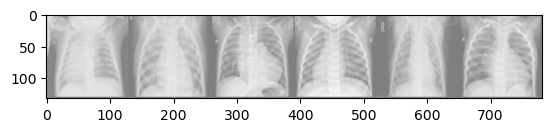

labels: tensor([1, 1, 1, 0, 1, 1])


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
it = iter(train_loader)
x, y = next(it)

print(x.shape)

# show images
imshow(torchvision.utils.make_grid(x[:6]))
print('labels:', y[:6])

In [5]:
import torch_directml
# select the GPU device if available
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch_directml.is_available():
    device = torch_directml.device(torch_directml.default_device())
else:
    device = torch.device("cpu")

In [67]:
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

class ConvNet(nn.Module):    
    def __init__(self, num_classes):
        super().__init__()

        self.pipeline = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, padding=3),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 16, kernel_size=5, padding=3),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.BatchNorm2d(8),
            nn.MaxPool2d(2),
        )
    
        # Final convolution is initialized differently from the rest
        final_conv = nn.Conv2d(8, num_classes, kernel_size=1)
        self.classifier = nn.Sequential(
                nn.Dropout(p=0.2), final_conv, nn.ReLU(inplace=True), nn.AdaptiveAvgPool2d((1, 1))
            )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                if m is final_conv:
                    init.normal_(m.weight, mean=0.0, std=0.01)
                else:
                    init.kaiming_uniform_(m.weight)
                if m.bias is not None:
                    init.constant_(m.bias, 0)
        
    def forward(self, x):
        x = self.pipeline(x)
        x = self.classifier(x)
        return torch.flatten(x, 1)

In [86]:
import torch.optim as optim

num_classes = 1
net = ConvNet(num_classes)
net.to(device)

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

num_params = sum(p.numel() for p in net.parameters())
num_params

17281

In [87]:
for epoch in range(100):
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        images, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        outputs = net(images)
        outputs = outputs.squeeze(1)
        # print('outputs', outputs)
        # print('labels', labels)
        loss = loss_fn(outputs, labels.float())
        # print('loss', loss)
        # break


        # backward & optimize
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / batch_size:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,   100] loss: 6.389
[1,   200] loss: 5.160
[1,   300] loss: 4.686
[1,   400] loss: 4.609
[1,   500] loss: 4.207
[2,   100] loss: 4.341
[2,   200] loss: 4.465
[2,   300] loss: 3.844
[2,   400] loss: 4.298
[2,   500] loss: 4.375
[3,   100] loss: 4.382
[3,   200] loss: 4.051
[3,   300] loss: 4.144
[3,   400] loss: 4.037
[3,   500] loss: 4.084
[4,   100] loss: 3.977
[4,   200] loss: 4.057
[4,   300] loss: 4.165
[4,   400] loss: 3.964
[4,   500] loss: 4.088
[5,   100] loss: 4.243
[5,   200] loss: 3.812
[5,   300] loss: 3.998
[5,   400] loss: 3.913
[5,   500] loss: 4.049
[6,   100] loss: 3.940
[6,   200] loss: 3.869
[6,   300] loss: 4.037
[6,   400] loss: 3.864
[6,   500] loss: 3.887
[7,   100] loss: 3.868
[7,   200] loss: 3.842
[7,   300] loss: 3.738
[7,   400] loss: 3.913
[7,   500] loss: 3.843
[8,   100] loss: 3.761
[8,   200] loss: 3.863
[8,   300] loss: 3.748
[8,   400] loss: 3.842
[8,   500] loss: 3.800
[9,   100] loss: 3.843
[9,   200] loss: 3.720
[9,   300] loss: 3.702
[9,   400] 

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2cf1075090>
Traceback (most recent call last):
  File "/home/hgoz/anaconda3/envs/06-image/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    def __del__(self):
KeyboardInterrupt: 


RuntimeError: Unknown error -2147467259

In [ ]:
PATH = './mnist_medical.pth'
torch.save(net.state_dict(), PATH)

In [81]:
net = ConvNet(num_classes)
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [84]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for X, y in test_loader:
        scores = net(X)
        _, predictions = scores.max(1)   
        n_samples += X.shape[0]
        n_correct += (predictions == y).sum().item()
        
    acc = n_correct / n_samples
    print(f'Accuracy = {100*acc:.2f}')

Accuracy = 37.50


# Using a pre-trained model

In [ ]:
# from torchvision.models import vit_b_16

# model = vit_b_16(pretrained=True)

# for param in model.parameters():
#     param.requires_grad = False

# model.classifier = nn.Linear(model.classifier.in_features, num_classes)

# for param in model.classifier.parameters():
#     param.requires_grad = True

# loss_fn = nn.BCEWithLogitsLoss()
